# Exploratory Data Analysis

In [1]:
#import 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import string
import re
import nltk
from wordcloud import WordCloud,STOPWORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from keras import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import collections
def RMSE(Y,YHAT):
    return np.sqrt(mean_squared_error(Y,YHAT))

stopwords=list(STOPWORDS)

plt.rc('figure',figsize=(20,11))

def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [2]:
a_data = pd.read_csv('AB_US_2020.csv',usecols=['id','name','latitude','longitude','room_type','price','minimum_nights','number_of_reviews','last_review','reviews_per_month','calculated_host_listings_count',
                                                                                'availability_365','city'])
a_data.head(3)

,id,name,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville


In [3]:
numeric_features = a_data.select_dtypes(include=['int64','float64']).columns
nominal_features = a_data.select_dtypes(include=['object'])
numeric_features=numeric_features.delete(0)

In [4]:
a_data = a_data.dropna()

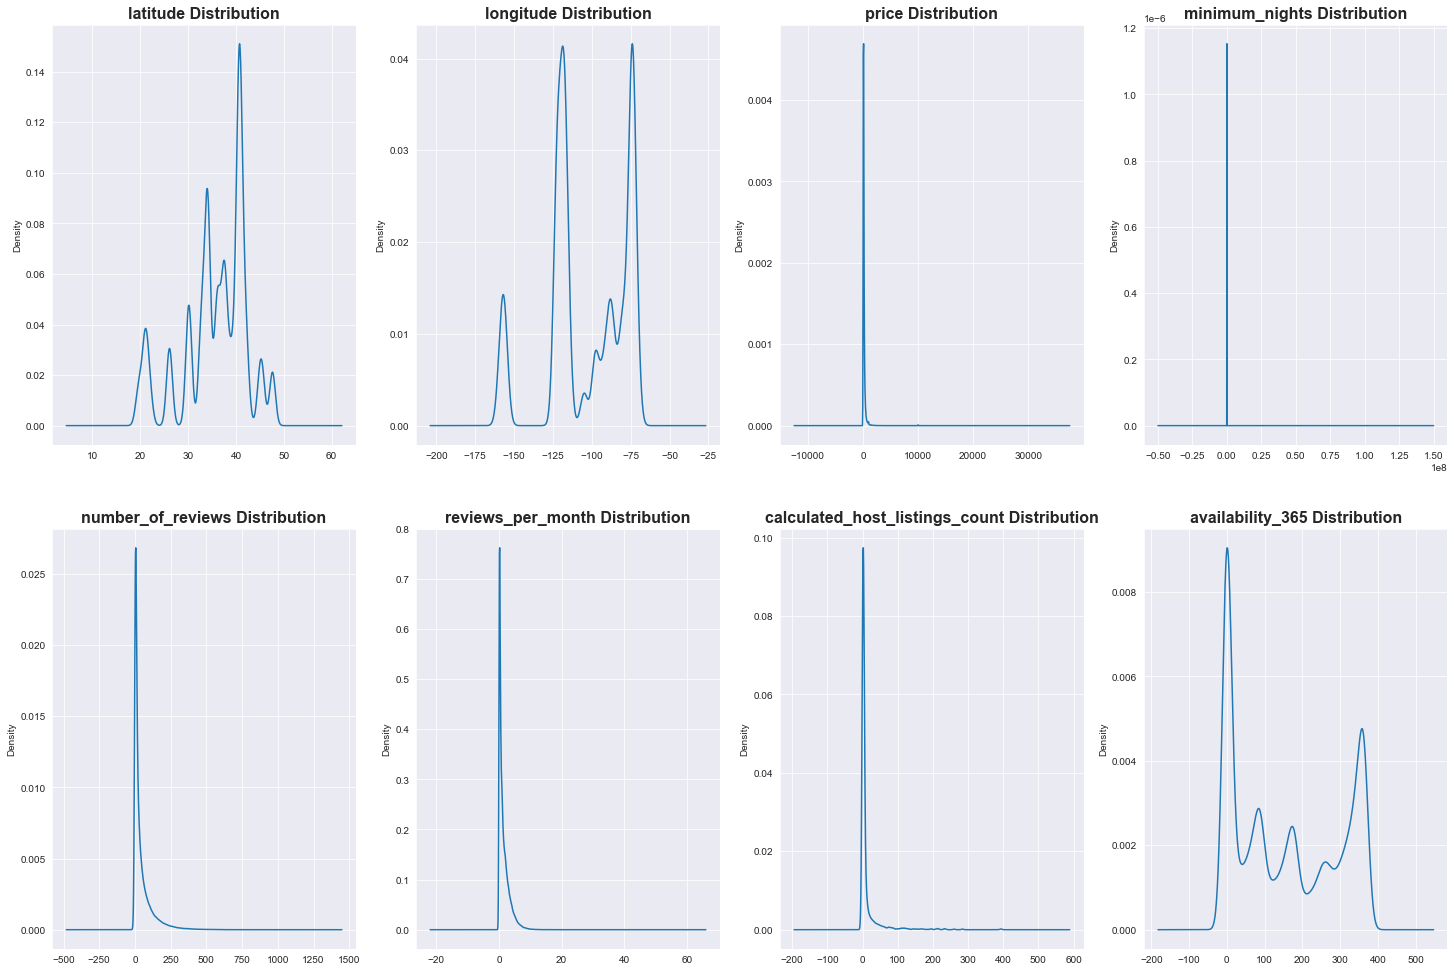

In [5]:
# Numeric Features Distribution Analysis
fig, axes = plt.subplots(nrows=2, ncols=4)
aux = 0
fig.set_figheight(17)
fig.set_figwidth(25)
for row in axes:
    for col in row:
        a_data[numeric_features[aux]].plot(kind='kde',ax=col)
        col.set_title(numeric_features[aux] +' Distribution',fontsize=16,fontweight='bold')
        aux+=1

In [6]:
# Outlier Removal
# Removing Outliers
lower_bound = .25
upper_bound = .75
iqr = a_data[a_data['price'].between(a_data['price'].quantile(lower_bound), a_data['price'].quantile(upper_bound), inclusive=True)]
iqr = iqr[iqr['number_of_reviews'] > 0]
iqr = iqr[iqr['calculated_host_listings_count'] < 10]
iqr = iqr[iqr['number_of_reviews'] < 200]
iqr = iqr[iqr['minimum_nights'] < 10]
iqr = iqr[iqr['reviews_per_month'] < 5]

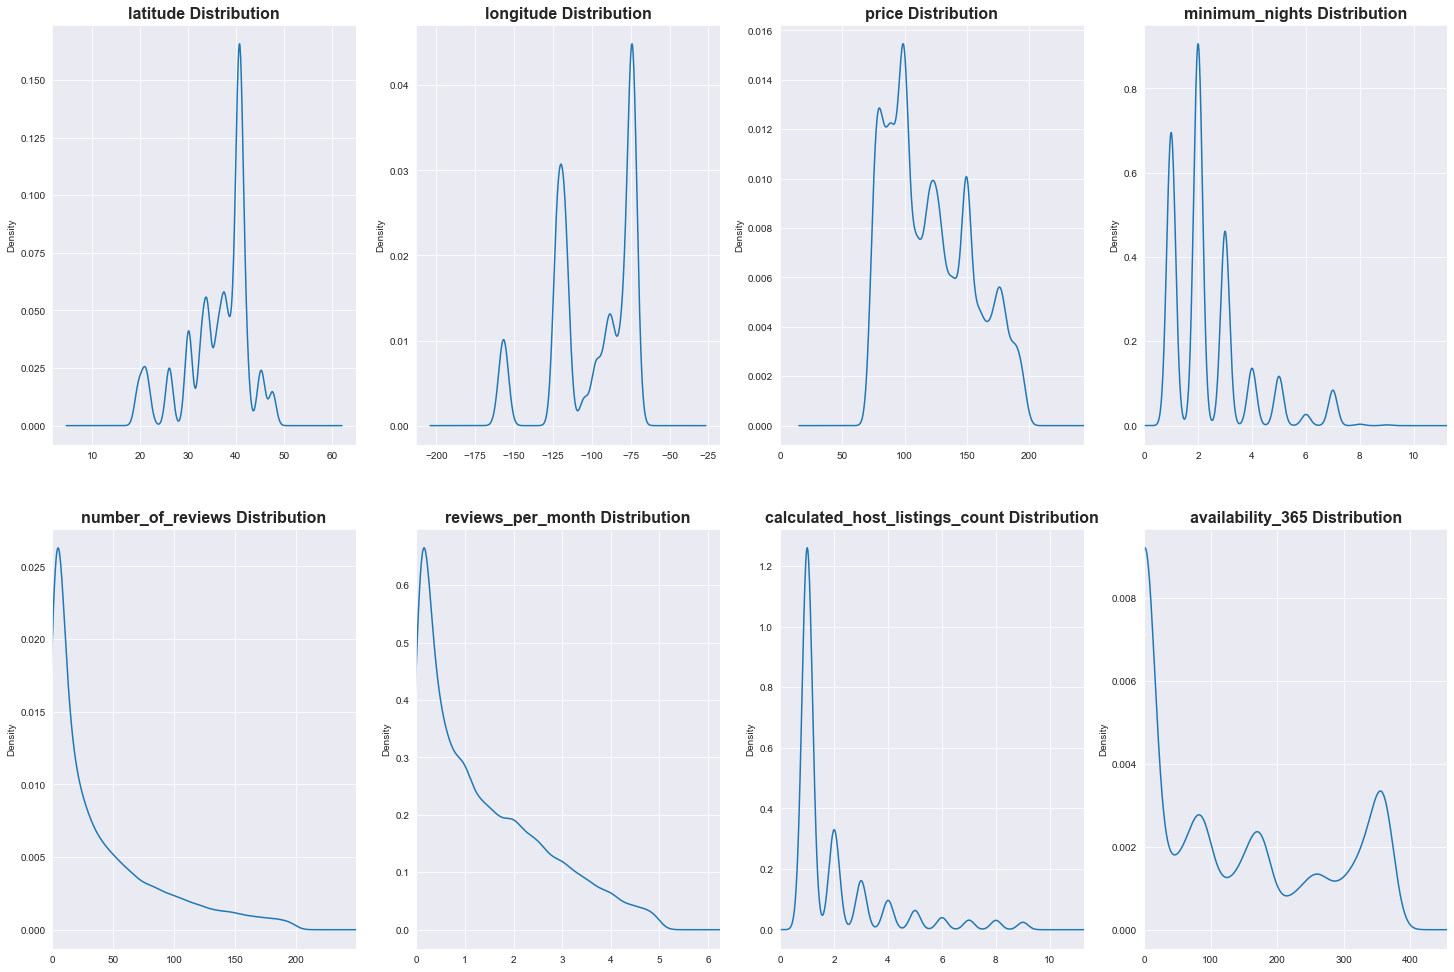

In [7]:
# Processed Distributions After Ourlier Removal
fig, axes = plt.subplots(nrows=2, ncols=4)
aux = 0
fig.set_figheight(17)
fig.set_figwidth(25)
for row in axes:
    for col in row:
        iqr[numeric_features[aux]].plot(kind='kde',ax=col)
        if numeric_features[aux] not in ['latitude','longitude']:
            col.set_xlim(0,iqr[numeric_features[aux]].max()+iqr[numeric_features[aux]].max()*0.25)
        col.set_title(numeric_features[aux] +' Distribution',fontsize=16,fontweight='bold')
        aux+=1

So we see that after we removed most of the outliers in our data we are left we more meaningful distributions from which we can extract some insight. We can see that the number_of_reveiws feature, as well as the reveiws_pre_month feature, follow an exponential distribution in contrast to all other numeric features in the dataset which seem to follow a multimodal distribution which makes sense because there are many underlying groups in our dataset (different location for example)

In [8]:
pr_data =iqr.copy()
desc = pr_data.describe()
desc.loc['skew'] = desc.skew()
desc.loc['skew'] = desc.kurt()
pd.set_option('display.float_format', lambda x: '%.5f' % x)
desc

,id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,54240.00000,54240.00000,54240.00000,54240.00000,54240.00000,54240.00000,54240.00000,54240.00000,54240.00000
mean,23532126.65017,36.30716,-99.26707,120.66729,2.39054,39.81374,1.37897,1.98003,134.10437
std,12487520.31611,6.66777,25.66866,33.37854,1.45147,45.53361,1.24405,1.73188,133.81626
min,344.00000,18.98232,-159.71143,75.00000,1.00000,1.00000,0.01000,1.00000,0.00000
25%,13878154.00000,32.79478,-118.39360,92.00000,1.00000,5.00000,0.30000,1.00000,0.00000
50%,23433545.50000,37.80744,-90.08964,115.00000,2.00000,21.00000,1.00000,1.00000,89.00000
75%,34419871.50000,40.73287,-73.98891,149.00000,3.00000,59.00000,2.19000,2.00000,259.00000
max,45492496.00000,47.73462,-70.99595,195.00000,9.00000,199.00000,4.99000,9.00000,365.00000
skew,-0.65301,8.99998,8.99974,8.99974,9.00000,8.99971,9.00000,9.00000,8.99878
